# Visualising high-dimensional datasets using PCA and t-SNE in Python

The first step around any data related challenge is to start by exploring the data itself. This could be by looking at, for example, the distributions of certain variables or looking at potential correlations between variables.

The problem nowadays is that most datasets have a large number of variables. In other words, they have a high number of dimensions along which the data is distributed. Visually exploring the data can then become challenging and most of the time even practically impossible to do manually. However, such visual exploration is incredibly important in any data-related problem. Therefore it is key to understand how to visualise high-dimensional datasets. This can be achieved using techniques known as dimensionality reduction. This post will focus on two techniques that will allow us to do this: PCA and t-SNE.

More about that later. Lets first get some (high-dimensional) data to work with.

## MNIST dataset
We will use the MNIST-dataset in this write-up. There is no need to download the dataset manually as we can grab it through using Scikit Learn.
First let’s get all libraries in place.

In [1]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In C:\MyApps\Anaconda3\envs\basicdl\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\MyApps\Anaconda3\envs\basicdl\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\MyApps\Anaconda3\envs\basicdl\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\MyApps\Anaconda3\envs\basicdl\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\MyApps\Anaconda3\envs\basicdl\lib\site-packages\matplo

and let’s then start by loading in the data

In [2]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
print(X.shape, y.shape)

(70000, 784) (70000,)


We are going to convert the matrix and vector to a Pandas DataFrame. This is very similar to the DataFrames used in R and will make it easier for us to plot it later on.

In [3]:
feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]
df = pd.DataFrame(X,columns=feat_cols)
df['y'] = y
df['label'] = df['y'].apply(lambda i: str(i))
X, y = None, None
print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (70000, 786)


Because we dont want to be using 70,000 digits in some calculations we’ll take a random subset of the digits. The randomisation is important as the dataset is sorted by its label (i.e., the first seven thousand or so are zeros, etc.). To ensure randomisation we’ll create a random permutation of the number 0 to 69,999 which allows us later to select the first five or ten thousand for our calculations and visualisations.

In [4]:
# For reproducability of the results
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])

We now have our dataframe and our randomisation vector. Lets first check what these numbers actually look like. To do this we’ll generate 30 plots of randomly selected images.

<Figure size 432x288 with 0 Axes>

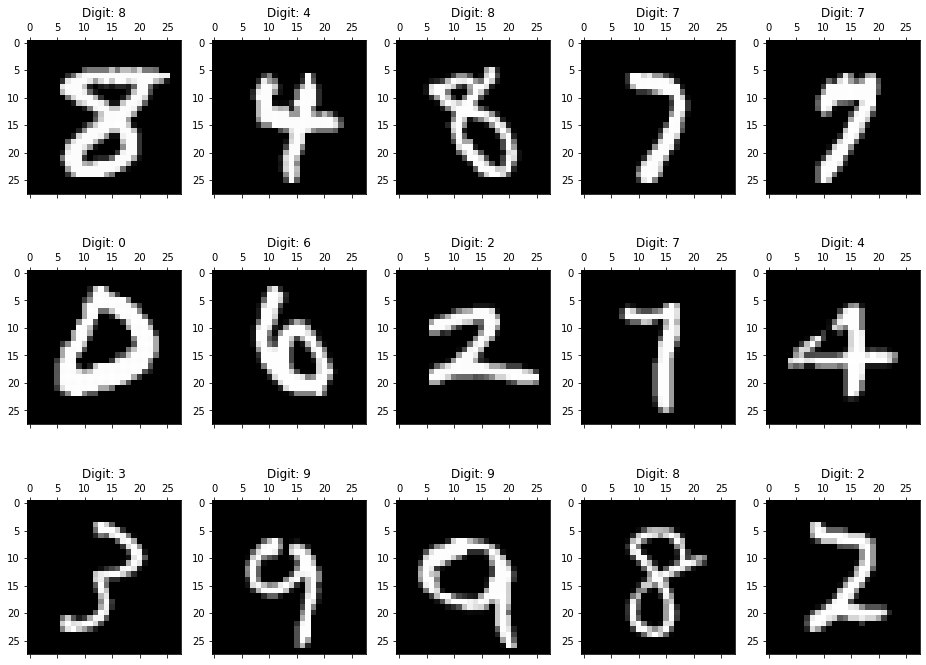

In [5]:
plt.gray()
fig = plt.figure(figsize=(16, 12))
for i in range(0, 15):
    ax = fig.add_subplot(3, 5, i+1, title="Digit: {}".format(str(df.loc[rndperm[i], 'label'])) )
    ax.matshow(df.loc[rndperm[i], feat_cols].values.reshape((28, 28)).astype(float))
plt.show()

Now we can start thinking about how we can actually distinguish the zeros from the ones and two’s and so on. If you were, for example, a post office such an algorithm could help you read and sort the handwritten envelopes using a machine instead of having humans do that. Obviously nowadays we have very advanced methods to do this, but this dataset still provides a very good testing ground for seeing how specific methods for dimensionality reduction work and how well they work.
The images are all essentially 28-by-28 pixel images and therefore have a total of 784 ‘dimensions’, each holding the value of one specific pixel.
What we can do is reduce the number of dimensions drastically whilst trying to retain as much of the ‘variation’ in the information as possible. This is where we get to dimensionality reduction. Lets first take a look at something known as Principal Component Analysis.

## Dimensionality reduction using PCA

PCA is a technique for reducing the number of dimensions in a dataset whilst retaining most information. It is using the correlation between some dimensions and tries to provide a minimum number of variables that keeps the maximum amount of variation or information about how the original data is distributed. It does not do this using guesswork but using hard mathematics and it uses something known as the eigenvalues and eigenvectors of the data-matrix. These eigenvectors of the covariance matrix have the property that they point along the major directions of variation in the data. These are the directions of maximum variation in a dataset.

I am not going to get into the actual derivation and calculation of the principal components — if you want to get into the mathematics see this great page — instead we’ll use the Scikit-Learn implementation of PCA.

Since we as humans like our two- and three-dimensional plots lets start with that and generate, from the original 784 dimensions, the first three principal components. And we’ll also see how much of the variation in the total dataset they actually account for.

In [6]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)
df['pca-one'] = pca_result[:, 0]
df['pca-two'] = pca_result[:, 1] 
df['pca-three'] = pca_result[:, 2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.09746116 0.07155445 0.06149531]


Now, given that the first two components account for about 25% of the variation in the entire dataset lets see if that is enough to visually set the different digits apart. What we can do is create a scatterplot of the first and second principal component and color each of the different types of digits with a different color. If we are lucky the same type of digits will be positioned (i.e., clustered) together in groups, which would mean that the first two principal components actually tell us a great deal about the specific types of digits.

<AxesSubplot:xlabel='pca-one', ylabel='pca-two'>

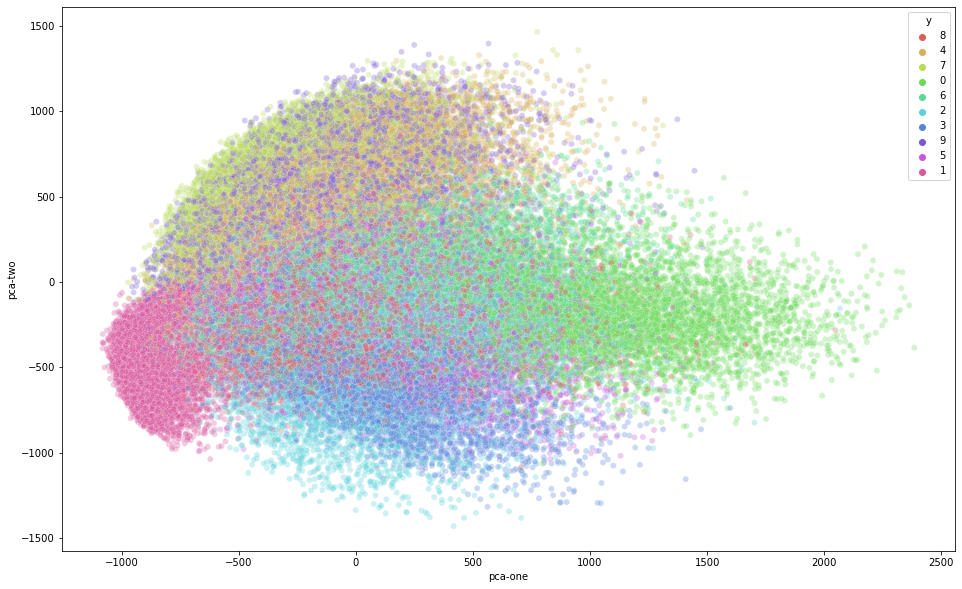

In [7]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df.loc[rndperm, :],
    legend="full",
    alpha=0.3
)

From the graph we can see the two components definitely hold some information, especially for specific digits, but clearly not enough to set all of them apart. Luckily there is another technique that we can use to reduce the number of dimensions that may prove more helpful. In the next few paragraphs we are going to take a look at that technique and explore if it gives us a better way of reducing the dimensions for visualisation. The method we will be exploring is known as t-SNE (t-Distributed Stochastic Neighbouring Entities).

For a 3d-version of the same plot

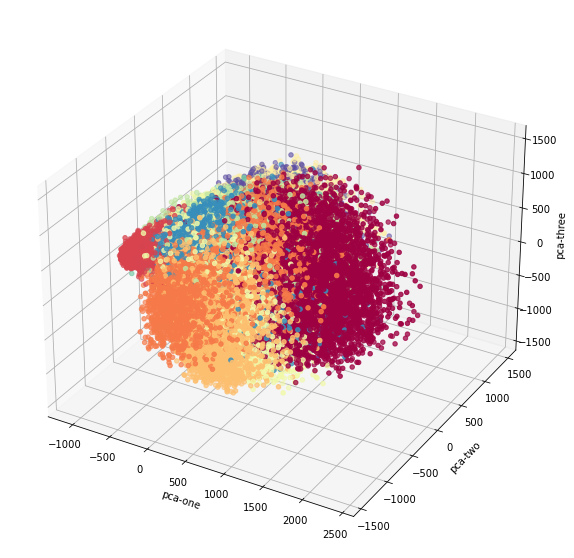

In [11]:
cmap = plt.cm.Spectral
norm = plt.Normalize(vmin=0, vmax=9)
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df.loc[rndperm,:]["pca-one"], 
    ys=df.loc[rndperm,:]["pca-two"], 
    zs=df.loc[rndperm,:]["pca-three"], 
    c=cmap(norm(df.loc[rndperm,:]["y"].astype(int))), 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## T-Distributed Stochastic Neighbouring Entities (t-SNE)

t-Distributed Stochastic Neighbor Embedding (t-SNE) is another technique for dimensionality reduction and is particularly well suited for the visualization of high-dimensional datasets. Contrary to PCA it is not a mathematical technique but a probablistic one. The original paper describes the working of t-SNE as:

“t-Distributed stochastic neighbor embedding (t-SNE) minimizes the divergence between two distributions: a distribution that measures pairwise similarities of the input objects and a distribution that measures pairwise similarities of the corresponding low-dimensional points in the embedding”.

Essentially what this means is that it looks at the original data that is entered into the algorithm and looks at how to best represent this data using less dimensions by matching both distributions. The way it does this is computationally quite heavy and therefore there are some (serious) limitations to the use of this technique. For example one of the recommendations is that, in case of very high dimensional data, you may need to apply another dimensionality reduction technique before using t-SNE:

>  It is highly recommended to use another dimensionality reduction
>  method (e.g. PCA for dense data or TruncatedSVD for sparse data)
>  to reduce the number of dimensions to a reasonable amount (e.g. 50)
>  if the number of features is very high.

The other key drawback is that it:

“Since t-SNE scales quadratically in the number of objects N, its applicability is limited to data sets with only a few thousand input objects; beyond that, learning becomes too slow to be practical (and the memory requirements become too large)”.

We will use the Scikit-Learn Implementation of the algorithm in the remainder of this writeup.

Contrary to the recommendation above we will first try to run the algorithm on the actual dimensions of the data (784) and see how it does. To make sure we don’t burden our machine in terms of memory and power/time we will only use the first 10,000 samples to run the algorithm on. To compare later on I’ll also run the PCA again on the subset.

In [13]:
N = 10000
df_subset = df.loc[rndperm[:N], :].copy()
data_subset = df_subset[feat_cols].values
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:, 0]
df_subset['pca-two'] = pca_result[:, 1] 
df_subset['pca-three'] = pca_result[:, 2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.09819946 0.07123677 0.06113222]


In [14]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

C:\MyApps\Anaconda3\envs\basicdl\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\MyApps\Anaconda3\envs\basicdl\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.009s...
[t-SNE] Computed neighbors for 10000 samples in 2.086s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 540.083306
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.851913
[t-SNE] KL divergence after 300 iterations: 2.786212
t-SNE done! Time elapse

Now that we have the two resulting dimensions we can again visualise them by creating a scatter plot of the two dimensions and coloring each sample by its respective label.

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

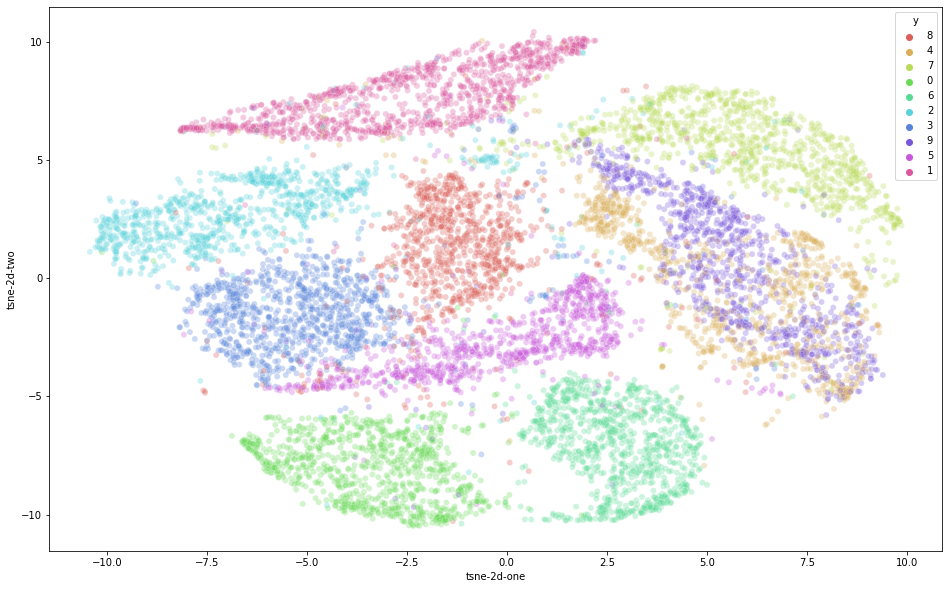

In [15]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)

This is already a significant improvement over the PCA visualisation we used earlier. We can see that the digits are very clearly clustered in their own sub groups. If we would now use a clustering algorithm to pick out the seperate clusters we could probably quite accurately assign new points to a label. Just to compare PCA & T-SNE:

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

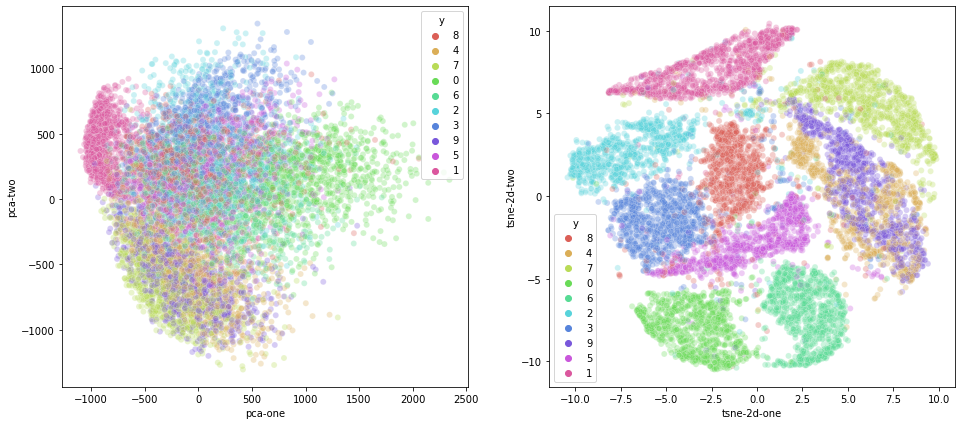

In [16]:
plt.figure(figsize=(16,7))
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax2
)

We’ll now take the recommendations to heart and actually reduce the number of dimensions before feeding the data into the t-SNE algorithm. For this we’ll use PCA again. We will first create a new dataset containing the fifty dimensions generated by the PCA reduction algorithm. We can then use this dataset to perform the t-SNE on

In [17]:
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(data_subset)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.8261701433205914


Amazingly, the first 50 components roughly hold around 85% of the total variation in the data.
Now lets try and feed this data into the t-SNE algorithm. This time we’ll use 10,000 samples out of the 70,000 to make sure the algorithm does not take up too much memory and CPU. Since the code used for this is very similar to the previous t-SNE code I have moved it to the Appendix: Code section at the bottom of this post. The plot it produced is the following one:

In [18]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_50)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

C:\MyApps\Anaconda3\envs\basicdl\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\MyApps\Anaconda3\envs\basicdl\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


t-SNE done! Time elapsed: 11.418391704559326 seconds


<AxesSubplot:xlabel='tsne-pca50-one', ylabel='tsne-pca50-two'>

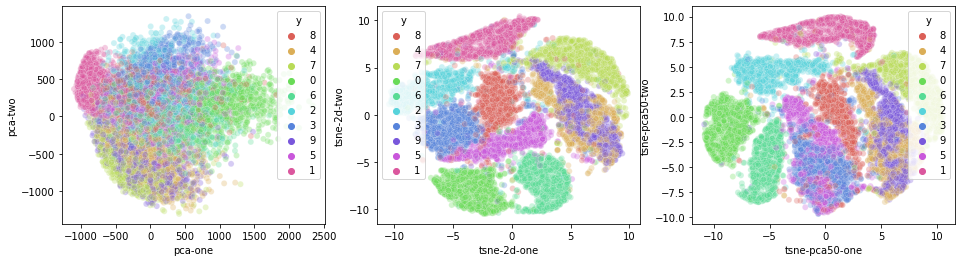

In [19]:
df_subset['tsne-pca50-one'] = tsne_pca_results[:,0]
df_subset['tsne-pca50-two'] = tsne_pca_results[:,1]
plt.figure(figsize=(16,4))
ax1 = plt.subplot(1, 3, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 3, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax2
)
ax3 = plt.subplot(1, 3, 3)
sns.scatterplot(
    x="tsne-pca50-one", y="tsne-pca50-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax3
)

From this plot we can clearly see how all the samples are nicely spaced apart and grouped together with their respective digits. This could be an amazing starting point to then use a clustering algorithm and try to identify the clusters or to actually use these two dimensions as input to another algorithm (e.g., something like a Neural Network).
So we have explored using various dimensionality reduction techniques to visualise high-dimensional data using a two-dimensional scatter plot. We have not gone into the actual mathematics involved but instead relied on the Scikit-Learn implementations of all algorithms.